In [ ]:
import numpy as np 
import pandas as pd 
import os

In [ ]:
paths = []
# Loop to collect paths to all images
for dirname, _, filenames in os.walk('/kaggle/input/cholecseg8k'):
    for filename in filenames:
        p = os.path.join(dirname, filename)
        paths.append(p)
files = pd.DataFrame(paths) 

In [ ]:
# split paths to get masks and images
files['mask_path'] = files[0].apply(lambda x: x if 'endo_watershed_mask' in x else None)
files['img_path'] = files[0].apply(lambda x: x if 'endo.png' in x else None)

# parse image ids
files['video'] = files[0].apply(lambda x: x.split('/')[5])
files['frame'] = files[0].apply(lambda x: x.split('/')[6].split('_')[1])
files

0  \
0      /kaggle/input/cholecseg8k/video18/video18_0113...   
1      /kaggle/input/cholecseg8k/video18/video18_0113...   
2      /kaggle/input/cholecseg8k/video18/video18_0113...   
3      /kaggle/input/cholecseg8k/video18/video18_0113...   
4      /kaggle/input/cholecseg8k/video18/video18_0113...   
...                                                  ...   
32315  /kaggle/input/cholecseg8k/video12/video12_1958...   
32316  /kaggle/input/cholecseg8k/video12/video12_1958...   
32317  /kaggle/input/cholecseg8k/video12/video12_1958...   
32318  /kaggle/input/cholecseg8k/video12/video12_1958...   
32319  /kaggle/input/cholecseg8k/video12/video12_1958...   

                                               mask_path  \
0                                                   None   
1                                                   None   
2      /kaggle/input/cholecseg8k/video18/video18_0113...   
3      /kaggle/input/cholecseg8k/video18/video18_0113...   
4                                                   None   
...                                                  ...   
32315                                               None   
32316                                               None   
32317                                               None   
32318                                               None   
32319                                               None   

                                                img_path          video  frame  
0                                                   None  video18_01139   1192  
1      /kaggle/input/cholecseg8k/video18/video18_0113...  video18_01139   1165  
2                                                   None  video18_01139   1184  
3                                                   None  video18_01139   1198  
4      /kaggle/input/cholecseg8k/video18/video18_0113...  video18_01139   1152  
...                                                  ...            ...    ...  
32315                                               None  video12_19580  19587  
32316  /kaggle/input/cholecseg8k/video12/video12_1958...  video12_19580  19615  
32317  /kaggle/input/cholecseg8k/video12/video12_1958...  video12_19580  19605  
32318                                               None  video12_19580  19633  
32319                                               None  video12_19580  19614  

[32320 rows x 5 columns]

In [ ]:
# get rid of redundant rows
data = files.groupby(['video', 'frame'], as_index=False).agg({'mask_path': 'sum', 'img_path':'sum'})
data

video frame                                          mask_path  \
0     video01_00080   100  /kaggle/input/cholecseg8k/video01/video01_0008...   
1     video01_00080   101  /kaggle/input/cholecseg8k/video01/video01_0008...   
2     video01_00080   102  /kaggle/input/cholecseg8k/video01/video01_0008...   
3     video01_00080   103  /kaggle/input/cholecseg8k/video01/video01_0008...   
4     video01_00080   104  /kaggle/input/cholecseg8k/video01/video01_0008...   
...             ...   ...                                                ...   
8075  video55_00668   743  /kaggle/input/cholecseg8k/video55/video55_0066...   
8076  video55_00668   744  /kaggle/input/cholecseg8k/video55/video55_0066...   
8077  video55_00668   745  /kaggle/input/cholecseg8k/video55/video55_0066...   
8078  video55_00668   746  /kaggle/input/cholecseg8k/video55/video55_0066...   
8079  video55_00668   747  /kaggle/input/cholecseg8k/video55/video55_0066...   

                                               img_path  
0     /kaggle/input/cholecseg8k/video01/video01_0008...  
1     /kaggle/input/cholecseg8k/video01/video01_0008...  
2     /kaggle/input/cholecseg8k/video01/video01_0008...  
3     /kaggle/input/cholecseg8k/video01/video01_0008...  
4     /kaggle/input/cholecseg8k/video01/video01_0008...  
...                                                 ...  
8075  /kaggle/input/cholecseg8k/video55/video55_0066...  
8076  /kaggle/input/cholecseg8k/video55/video55_0066...  
8077  /kaggle/input/cholecseg8k/video55/video55_0066...  
8078  /kaggle/input/cholecseg8k/video55/video55_0066...  
8079  /kaggle/input/cholecseg8k/video55/video55_0066...  

[8080 rows x 4 columns]

In [ ]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

In [ ]:
# I am using segmentation-models-pytorch for experiments
!pip install -q -U segmentation-models-pytorch albumentations
import segmentation_models_pytorch as smp

In [ ]:
# Train test split

# My train-test split is based on videos, so I may not worry about overfitting

train_videos = ['video18',
                 'video09',
                 'video35',
                 'video20',
                 'video01',
                 'video52',
                 'video43',
                 'video55',
                 'video28',
                'video48',
                 'video27',
                'video26',
                'video12',
               ]
valid_videos = [
                 'video17',
                 'video24'                 
                 'video37',
                'video25',


                 ]

# For some reason the class ids in the dataset are not ordered. I have to fix it

ids = [255, 5, 11, 12, 13, 21, 22, 23, 24, 25, 31, 32, 33, 35, 36, 50]
replace = {k:i for i, k in enumerate(ids)}

In [ ]:
# A function to map old ids to new ones
def mp(entry):
    return replace[entry] if entry in replace else entry

In [ ]:
# just vectorizing this function for robustness
mp = np.vectorize(mp)

In [ ]:
from tensorflow.keras.utils import to_categorical


class Cholec8KDataset(torch.utils.data.Dataset):
    def __init__(
            self, 
            df,
            n_classes=16,
            augmentation=None, 
            preprocessing=None,
            distortion=False,
    ):
        self.image_paths = df['img_path'].tolist()
        self.mask_paths = df['mask_path'].tolist()
        self.n_classes = n_classes
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.distortion = distortion
    
    def __getitem__(self, i):
        
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
        # the mask has 3 channels, but the value is the same in all channels
        # so using only one channel is fine
        mask = mp(mask[:, :, 0])
        # using to_categorical to transfer a single mask to multiple masks
        mask = to_categorical(mask, num_classes=self.n_classes,dtype ="float32" if self.distortion else 'int32')
        if self.distortion:
            image = album.augmentations.functional.optical_distortion(image, k=4, dx=0, dy=0, interpolation=1, border_mode=0, value=None)
            mask = album.augmentations.functional.optical_distortion(mask, k=4, dx=0, dy=0, interpolation=1, border_mode=0, value=None)
            mask = mask.astype('int32')
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
      
        return image, mask
        
    def __len__(self):
        return len(self.image_paths)

In [ ]:
def get_training_augmentation():
    train_transform = [
        album.HorizontalFlip(p=0.5),
        album.Resize(256, 256) # it is important to resize images in this dataset
    ]
    return album.Compose(train_transform)


def get_validation_augmentation():
    test_transform = [
        album.Resize(256, 256) # no need to add additional augmentations
    ]
    return album.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    return album.Compose(_transform)

In [ ]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = 16
ACTIVATION = 'softmax2d' # I am using a multi class segmentation, so
                         # softmax is preferrable

model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=CLASSES, 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
data['vid'] = data['video'].apply(lambda x: x.split('_')[0])


In [ ]:
train_dataset = Cholec8KDataset(
    data.loc[data['vid'].isin(train_videos)], 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
)

valid_dataset = Cholec8KDataset(
    data.loc[data['vid'].isin(valid_videos)], 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
)

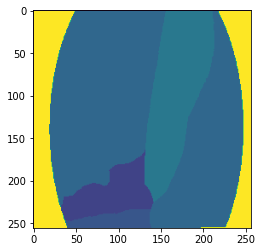

In [ ]:
plt.imshow(np.argmax(train_dataset[0][1], axis=0))

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=4)

In [ ]:
TRAINING = True

EPOCHS = 5

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
loss =  smp.utils.losses.CrossEntropyLoss()
# define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.Fscore(threshold=0.5),
    smp.utils.metrics.Accuracy(threshold=0.5),
    smp.utils.metrics.Recall(threshold=0.5),
    smp.utils.metrics.Precision(threshold=0.5),
]


# define optimizer
optimizer = torch.optim.AdamW([ 
    dict(params=model.parameters(), lr=0.0007),
])

In [ ]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)
valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [ ]:
if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model saved!')


Epoch: 0
valid: 100%|██████████| 40/40 [01:31<00:00,  2.30s/it, cross_entropy_loss - 1.951, iou_score - 0.8664, fscore - 0.928, accuracy - 0.991, recall - 0.9257, precision - 0.9303]
Model saved!

Epoch: 1
valid: 100%|██████████| 40/40 [01:31<00:00,  2.28s/it, cross_entropy_loss - 1.951, iou_score - 0.8624, fscore - 0.9254, accuracy - 0.9907, recall - 0.9235, precision - 0.9272]

Epoch: 2
valid: 100%|██████████| 40/40 [01:29<00:00,  2.24s/it, cross_entropy_loss - 1.935, iou_score - 0.8901, fscore - 0.9415, accuracy - 0.9927, recall - 0.9403, precision - 0.9427]
Model saved!

Epoch: 3
valid: 100%|██████████| 40/40 [01:30<00:00,  2.26s/it, cross_entropy_loss - 1.951, iou_score - 0.8607, fscore - 0.9244, accuracy - 0.9906, recall - 0.9234, precision - 0.9254]

Epoch: 4
valid: 100%|██████████| 40/40 [01:30<00:00,  2.25s/it, cross_entropy_loss - 1.935, iou_score - 0.8902, fscore - 0.9413, accuracy - 0.9927, recall - 0.9405, precision - 0.9422]
Model saved!


In [ ]:
torch.save(model.state_dict(), "original_model_ce.pth")

### Visualize perfomance

In [ ]:
model.load_state_dict(torch.load('original_model_ce.pth'))

<All keys matched successfully>

In [ ]:
DEVICE = torch.device('cpu')
model.eval()
model.to(DEVICE);

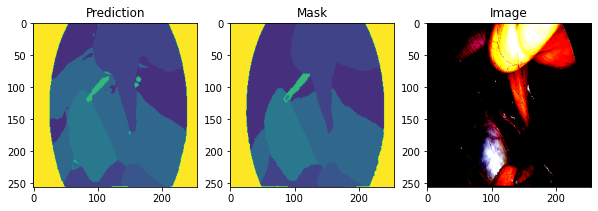

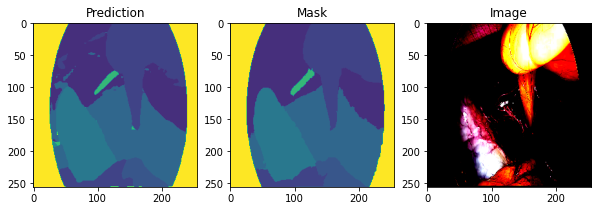

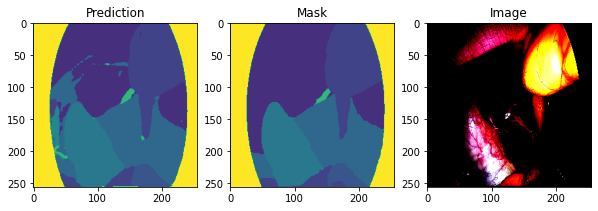

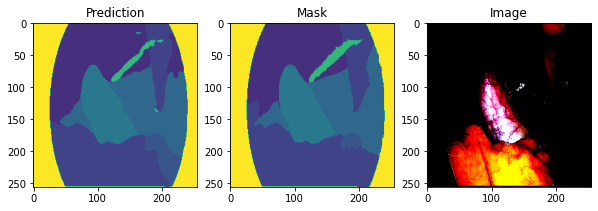

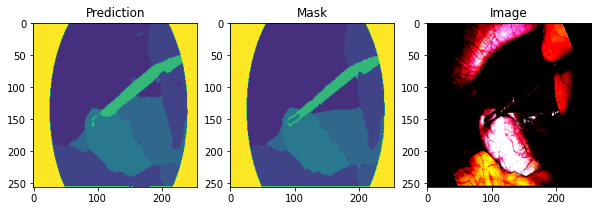

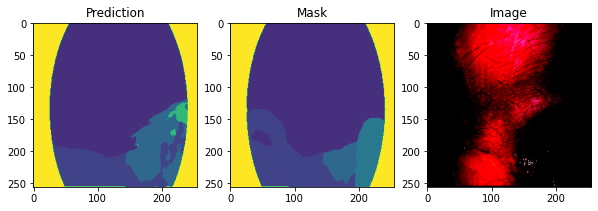

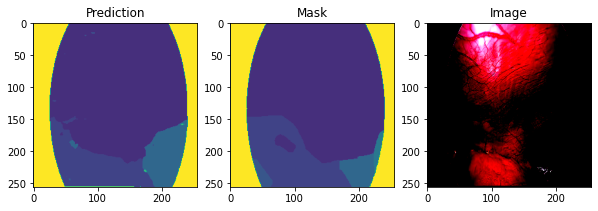

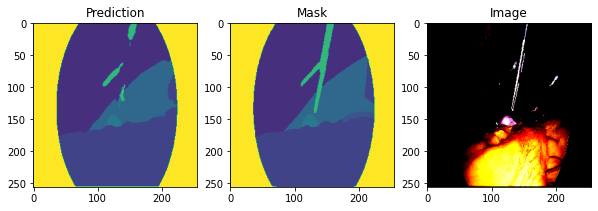

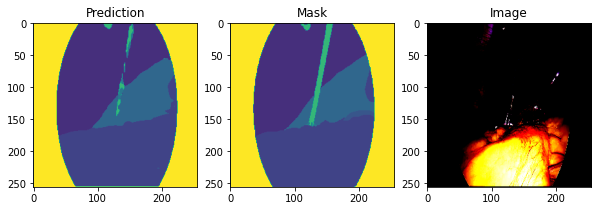

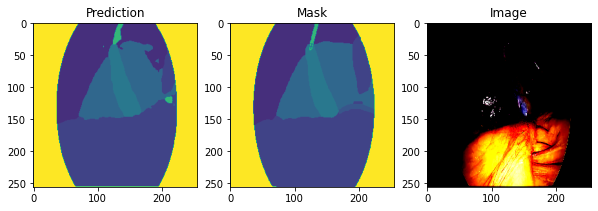

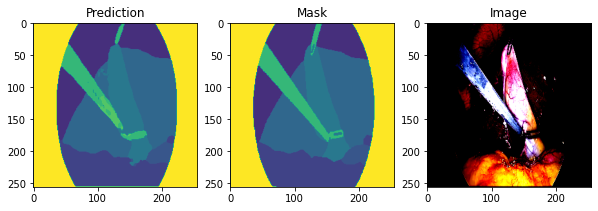

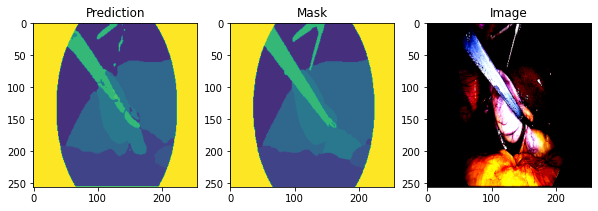

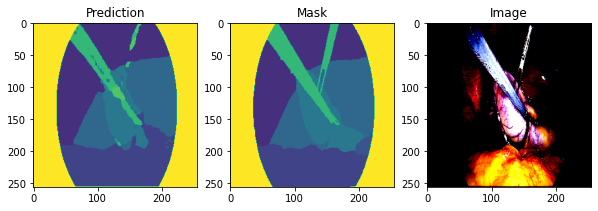

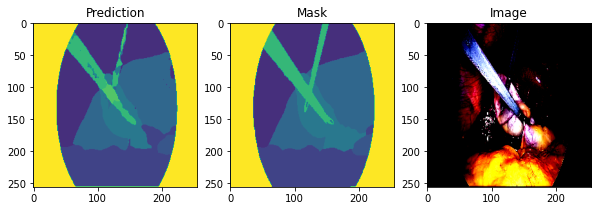

In [ ]:
c = 0
for i in valid_loader:
    if c % 3 == 0:
        f, axarr = plt.subplots(1,3, figsize=(10, 10))
        preds = model(i[0].to(DEVICE))
        preds = torch.argmax(preds, axis=1)
        axarr[0].imshow(preds[0, :, :].cpu().numpy())
        axarr[0].set_title("Prediction")
        mask = i[1][0].cpu().numpy()
        axarr[1].imshow(np.argmax(mask, axis=0))
        axarr[1].set_title("Mask")
        img = i[0][0].cpu().numpy()
        img = np.transpose(img,(1,2,0))
        axarr[2].imshow(img)
        axarr[2].set_title("Image")
        plt.show()
    c += 1

In [ ]:
class Cholec8KDataset_diceOptimized(torch.utils.data.Dataset):
    def __init__(
            self, 
            df,
            n_classes=16,
            augmentation=None, 
            preprocessing=None,
            distortion=False,
    ):
        self.image_paths = df['img_path'].tolist()
        self.mask_paths = df['mask_path'].tolist()
        self.n_classes = n_classes
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.distortion = distortion
    
    def __getitem__(self, i):
        
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
        # the mask has 3 channels, but the value is the same in all channels
        # so using only one channel is fine
        mask = mp(mask[:, :, 0])
        # using to_categorical to transfer a single mask to multiple masks
        if self.distortion:
            mask = to_categorical(mask, num_classes=self.n_classes,dtype ="float32" if self.distortion else 'int32')
            image = album.augmentations.functional.optical_distortion(image, k=4, dx=0, dy=0, interpolation=1, border_mode=0, value=None)
            mask = album.augmentations.functional.optical_distortion(mask, k=4, dx=0, dy=0, interpolation=1, border_mode=0, value=None)
            mask = np.array(np.argmax(mask, axis=2))
        mask = mask[:, :, np.newaxis]  
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
      
        return image, mask[0, :, :].astype('long') 
        
    def __len__(self):
        return len(self.image_paths)

In [ ]:
train_dataset = Cholec8KDataset_diceOptimized(
    data.loc[data['vid'].isin(train_videos)], 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
)

valid_dataset = Cholec8KDataset_diceOptimized(
    data.loc[data['vid'].isin(valid_videos)], 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=4)

In [ ]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = 16
ACTIVATION = "softmax2d" 

model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=CLASSES, 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [ ]:
TRAINING = True

EPOCHS = 5

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
loss =  smp.losses.DiceLoss(mode='multiclass')
loss.__name__ = 'dice loss mc'
# define metrics
metrics = [
    smp.utils.metrics.Precision(threshold=0.5),
    smp.utils.metrics.Recall(threshold=0.5),
    smp.utils.metrics.Fscore(threshold=0.5),
    smp.utils.metrics.IoU(threshold=0.5),
]
# define optimizer
optimizer = torch.optim.AdamW([ 
    dict(params=model.parameters(), lr=0.0007),
])

In [ ]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)
valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [ ]:
if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['dice loss mc']:
            best_iou_score = valid_logs['dice loss mc']
            torch.save(model, './best_model.pth')
            print('Model saved!')

In [ ]:
torch.save(model.state_dict(), "original_model_dice.pth")


### Visualize model perfomance



In [ ]:
model.load_state_dict(torch.load('original_model_dice.pth'))
DEVICE = torch.device('cpu')
model.eval()
model.to(DEVICE);

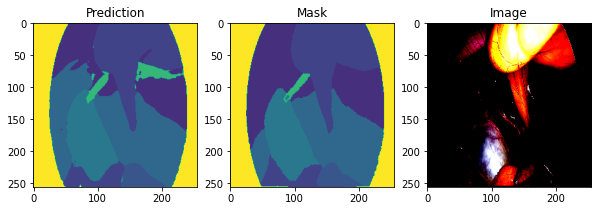

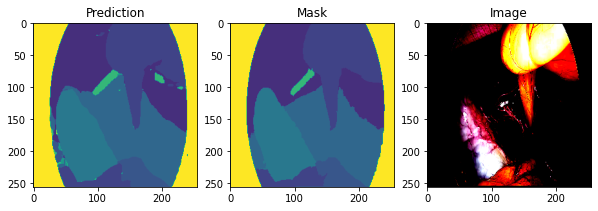

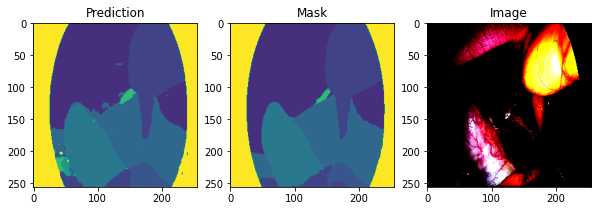

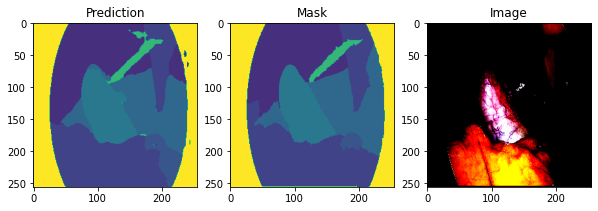

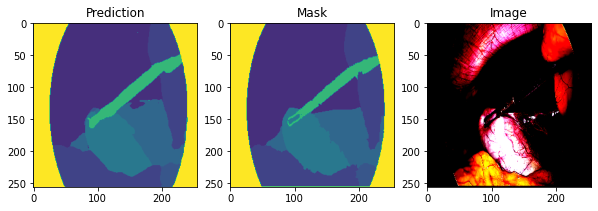

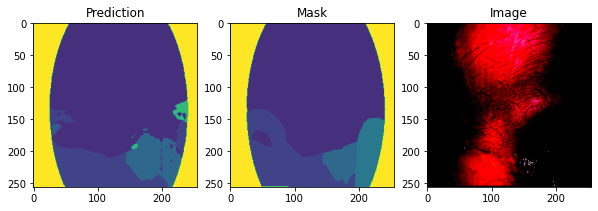

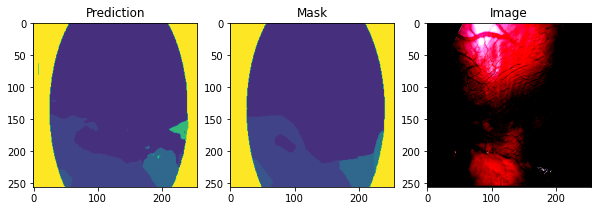

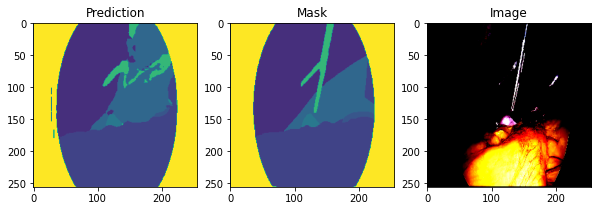

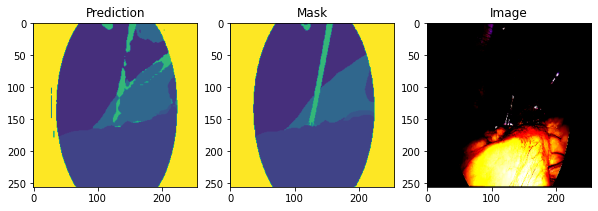

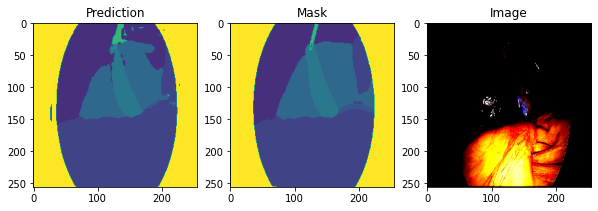

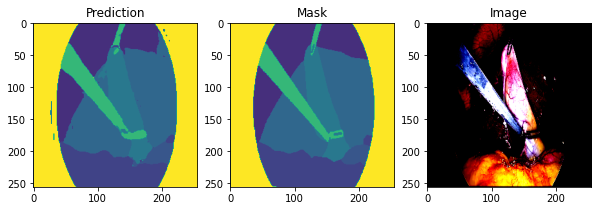

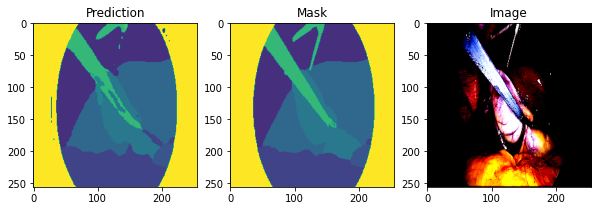

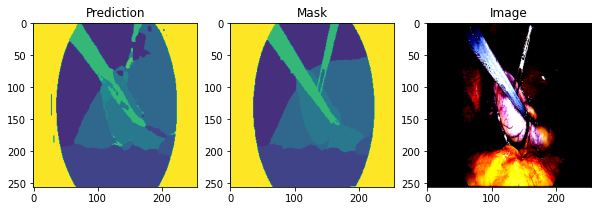

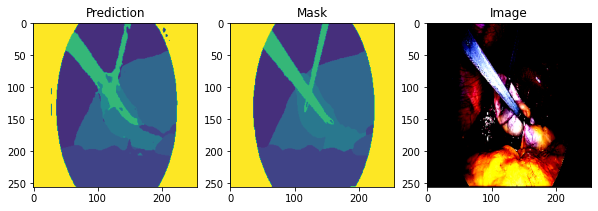

In [ ]:
c = 0
for i in valid_loader:
    if c % 3 == 0:
        f, axarr = plt.subplots(1,3, figsize=(10,10))
        preds = model(i[0].to(DEVICE))
        preds = torch.argmax(preds, axis=1)
        axarr[0].imshow(preds[0, :, :].cpu().numpy())
        axarr[0].set_title("Prediction")

        mask = i[1][0]
        axarr[1].imshow(mask.cpu().numpy())
        axarr[1].set_title("Mask")

        img = i[0][0].cpu().numpy()
        img = np.transpose(img,(1,2,0))
        axarr[2].imshow(img)
        axarr[2].set_title("Image")

        plt.show()
    c += 1

The perofance of the model trained using dice loss is roughly the same as the perfomance of the model training using Cross Entropy loss (metrics are the same).

## Distorted model

In [ ]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = 16
ACTIVATION = 'softmax2d' 

model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=CLASSES, 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [ ]:
train_dataset = Cholec8KDataset(
    data.loc[data['vid'].isin(train_videos)], 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    distortion=True, # the only difference from the previous part is this param
)

valid_dataset = Cholec8KDataset(
    data.loc[data['vid'].isin(valid_videos)], 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    distortion=True, # the only difference from the previous part is this param
)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=4)

In [ ]:
TRAINING = True
EPOCHS = 5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss = smp.utils.losses.CrossEntropyLoss() 
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.Fscore(threshold=0.5),
    smp.utils.metrics.Accuracy(threshold=0.5),
    smp.utils.metrics.Recall(threshold=0.5),
    smp.utils.metrics.Precision(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0007),
])

In [ ]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)
valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [ ]:
if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model saved!')


Epoch: 0
valid: 100%|██████████| 40/40 [01:41<00:00,  2.54s/it, cross_entropy_loss - 0.7788, iou_score - 0.5981, fscore - 0.7477, accuracy - 0.9854, recall - 0.8865, precision - 0.6467]
Model saved!

Epoch: 1
valid: 100%|██████████| 40/40 [01:42<00:00,  2.55s/it, cross_entropy_loss - 0.7607, iou_score - 0.3803, fscore - 0.5509, accuracy - 0.9628, recall - 0.9328, precision - 0.3909]

Epoch: 2
valid: 100%|██████████| 40/40 [01:41<00:00,  2.53s/it, cross_entropy_loss - 0.7634, iou_score - 0.6575, fscore - 0.7928, accuracy - 0.9882, recall - 0.9248, precision - 0.6941]
Model saved!

Epoch: 3
valid: 100%|██████████| 40/40 [01:39<00:00,  2.50s/it, cross_entropy_loss - 0.7694, iou_score - 0.6134, fscore - 0.7564, accuracy - 0.9853, recall - 0.9103, precision - 0.6495]

Epoch: 4
valid: 100%|██████████| 40/40 [01:40<00:00,  2.52s/it, cross_entropy_loss - 0.7678, iou_score - 0.4549, fscore - 0.6246, accuracy - 0.9731, recall - 0.9127, precision - 0.4749]


In [ ]:
torch.save(model.state_dict(), "distorted_model_ce.pth")


The best model has IoU score of 0.65, which is 0.24 worse than the perfomance of original model. The score degradation looks significant, but we have to visualize the model outputs to decide if it is visually worse.

### Visualize model perfomance

In [ ]:
model.load_state_dict(torch.load('distorted_model_ce.pth'))

<All keys matched successfully>

In [ ]:
DEVICE = torch.device('cpu')
model.eval()
model.to(DEVICE);

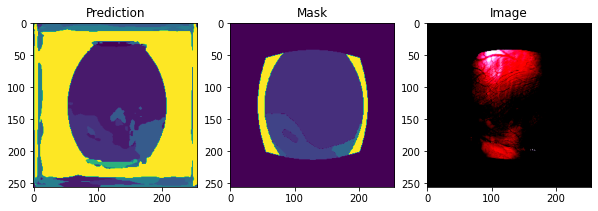

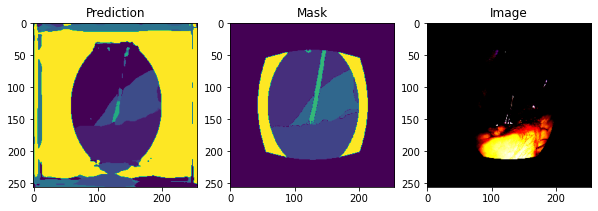

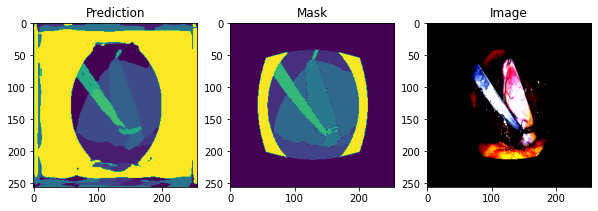

In [ ]:
c = 0
for i in valid_loader:
    if c % 3 == 0:
        f, axarr = plt.subplots(1,3, figsize=(10, 10))
        preds = model(i[0].to(DEVICE))
        preds = torch.argmax(preds, axis=1)
        axarr[0].imshow(preds[0, :, :].cpu().numpy())
        axarr[0].set_title("Prediction")
        mask = i[1][0].cpu().numpy()
        axarr[1].imshow(np.argmax(mask, axis=0))
        axarr[1].set_title("Mask")
        img = i[0][0].cpu().numpy()
        img = np.transpose(img,(1,2,0))
        axarr[2].imshow(img)
        axarr[2].set_title("Image")
        plt.show()
    c += 1

The main issue is with segmentation of backgrounds. Surgical tools and organs are segmented fine, but there is a room for improvement. 

In [ ]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = 16
ACTIVATION = 'softmax2d' 

model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=CLASSES, 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [ ]:
train_dataset = Cholec8KDataset_diceOptimized(
    data.loc[data['vid'].isin(train_videos)], 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    distortion=True,
)

valid_dataset = Cholec8KDataset_diceOptimized(
    data.loc[data['vid'].isin(valid_videos)], 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    distortion=True,
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=4)

In [ ]:
TRAINING = True

EPOCHS = 5

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
loss =  smp.losses.DiceLoss(mode='multiclass')
loss.__name__ = 'dice loss mc'
# define metrics
metrics = [
    smp.utils.metrics.Precision(threshold=0.5),
    smp.utils.metrics.Recall(threshold=0.5),
    smp.utils.metrics.Fscore(threshold=0.5),
    smp.utils.metrics.IoU(threshold=0.5),
]
# define optimizer
optimizer = torch.optim.AdamW([ 
    dict(params=model.parameters(), lr=0.0003),
])

In [ ]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)
valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=False,
)

In [ ]:
if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['dice loss mc']:
            best_iou_score = valid_logs['dice loss mc']
            torch.save(model, './best_model.pth')
            print('Model saved!')

In [ ]:
torch.save(model.state_dict(), "distorted_model_dice.pth")


### Visualize model

In [ ]:
model.load_state_dict(torch.load('distorted_model_dice.pth'))
DEVICE = torch.device('cpu')
model.eval()
model.to(DEVICE);

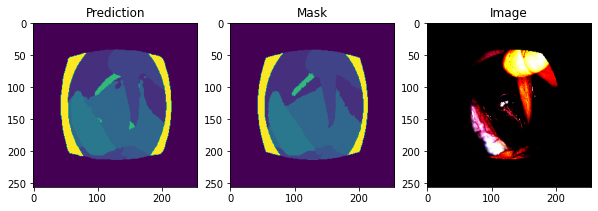

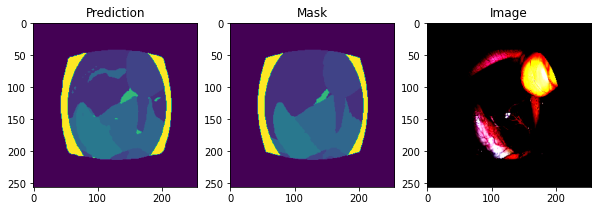

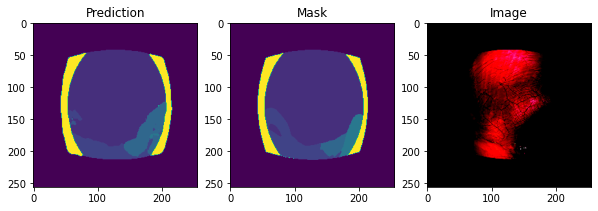

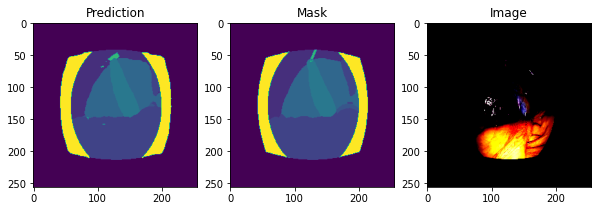

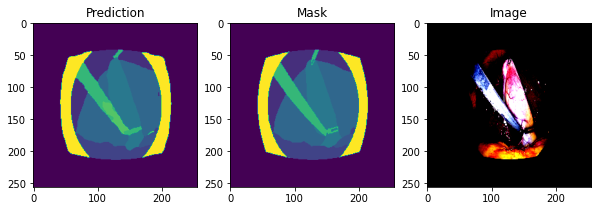

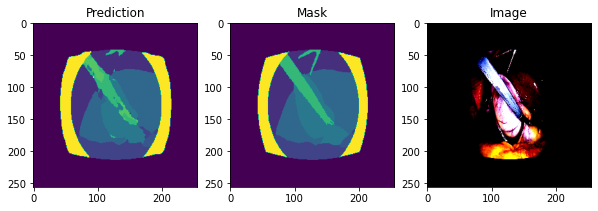

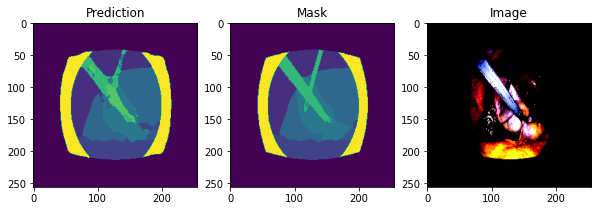

In [ ]:
c = 0
for i in valid_loader:
    if c % 3 == 0:
        f, axarr = plt.subplots(1,3,  figsize=(10, 10))
        preds = model(i[0].to(DEVICE))
        preds = torch.argmax(preds, axis=1)
        axarr[0].imshow(preds[0, :, :].cpu().numpy())
        axarr[0].set_title("Prediction")

        mask = i[1][0]
        axarr[1].imshow(mask.cpu().numpy())
        axarr[1].set_title("Mask")

        img = i[0][0].cpu().numpy()
        img = np.transpose(img,(1,2,0))
        axarr[2].imshow(img)
        axarr[2].set_title("Image")

        plt.show()
    c += 1

## Conclusion

From the experiment above it is clearly seen that a model for multu class segmentation of organs and surgical tools can be easily adapted for use in VR environment. The best result was achieved using a model, trained with multi class Dice Loss. Such a model easily segments surgical tools and has no problems with segmentation of organs.